In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import numpy as np
import os
import networkx as nx

In [2]:
#Get Top 11 cities from Europe in terms of population
cities = pd.read_csv('data/Top50/top50cities.csv',delimiter=',')

In [4]:
cities

,Unnamed: 0,name,population,lat,lng,countryId,countryName,countryCode,fclName,geonameId
0,0,Moscow,10381222,55.75222,37.61556,2017370,Russia,RU,"city, village,...",524901
1,1,London,7556900,51.50853,-0.12574,2635167,United Kingdom,GB,"city, village,...",2643743
2,2,St Petersburg,5028000,59.93863,30.31413,2017370,Russia,RU,"city, village,...",498817
3,3,Berlin,3426354,52.52437,13.41053,2921044,Germany,DE,"city, village,...",2950159
4,4,Madrid,3255944,40.41650,-3.70256,2510769,Spain,ES,"city, village,...",3117735
5,5,Rome,2318895,41.89193,12.51133,3175395,Italy,IT,"city, village,...",3169070
6,6,Kyiv,2797553,50.45466,30.52380,690791,Ukraine,UA,"city, village,...",703448
7,7,Paris,2138551,48.85341,2.34880,3017382,France,FR,"city, village,...",2988507
8,8,Bucharest,1877155,44.43225,26.10626,798549,Romania,RO,"city, village,...",683506
9,9,Budapest,1741041,47.49801,19.03991,719819,Hungary,HU,"city, village,...",3054643


In this part we import all the user we found for the top 11 populated cities in Europe, that was active within the last 6 months and which profil is verified.
Each user is a node. On the couchsurfing website a User can either be a host or a surfer.
Therefore we are doing the same.

In [5]:
#import nodes to get id from nodes/hosts
hosts = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    for p in range(1,14):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv',index_col=False)
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
print(len(hosts))
hosts=hosts.drop_duplicates()
print(len(hosts))

7722
7718


Each User has a section in his or her profile where other users write reviews about their couchsurfing experience with this user.
The reviews come from other users that eiter hosted the user or getting hosted by the user. 

In [6]:
rev = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    if os.path.exists('data/Top50//reviews/'+city['name']+'Rev.csv'):
        df = pd.read_csv('data/Top50/reviews/'+city['name']+'Rev.csv',index_col=False)
        rev = pd.concat([rev,df]).reset_index(drop=True)
print(len(rev))
rev=rev.drop_duplicates()
print(len(rev))



66261
66256


Now we are creating the graph that represent the network for all downloaded users.

Each node represents a user.

Each link represents a couchsurfing experience two couchsurfers had together.
We will create a directed graph in wich an a surf experience is an out degree, whereas a in degree represents a host experience.

In [10]:
#Creating the graph G
G = nx.DiGraph()
links = []
user_id_unique=set(hosts['id'].tolist())
#G.add_nodes_from(user_id_unique)
G.add_nodes_from([(rows['id'],{'city':rows['city']}) for idx,rows in hosts.iterrows()])

G.add_edges_from([(rows['to'],rows['from'])for index,rows in rev[['to','from','relationshipType']].iterrows() if rows['relationshipType']=='host'])
G.add_edges_from([(rows['from'],rows['to'])for index,rows in rev[['to','from','relationshipType']].iterrows() if rows['relationshipType']=='surf'])




In [11]:
d=G.degree()
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)
#forceatlas2 = ForceAtlas2()
#positions = forceatlas2.forceatlas2_networkx_layout(G,pos=None,iterations=1500)




100%|██████████| 100/100 [09:48<00:00,  4.82s/it]

BarnesHut Approximation  took  44.44  seconds
Repulsion forces  took  540.54  seconds
Gravitational forces  took  0.36  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  1.74  seconds


In [12]:
# create empty list for node colors
def random_color():
    return np.random.choice(range(256), size=3)/256# for each node in the graph
import matplotlib
def getColorfromCmap(val):
    cmap = matplotlib.cm.get_cmap('tab20')
    return cmap(val)


cmap = matplotlib.cm.get_cmap('Spectral')
cmap2 = matplotlib.cm.get_cmap('tab20')
node_color = []
legend_city=[city['name'] for idx,city in cities.iterrows()]
legend_city.append('outside')
legend_col=[getColorfromCmap(idx/(len(legend_city)-1)) for idx,x in enumerate(legend_city)]




for node in G.nodes(data=True):
    if node[1]:
        for idx,city in cities.iterrows():#_DK.loc[cities['2017']>50000].iterrows():
            if city['name'] in node[1]['city']:
                node_color.append(legend_col[idx])
    else:
        node_color.append(legend_col[10])



Nodesize represents the number of degrees

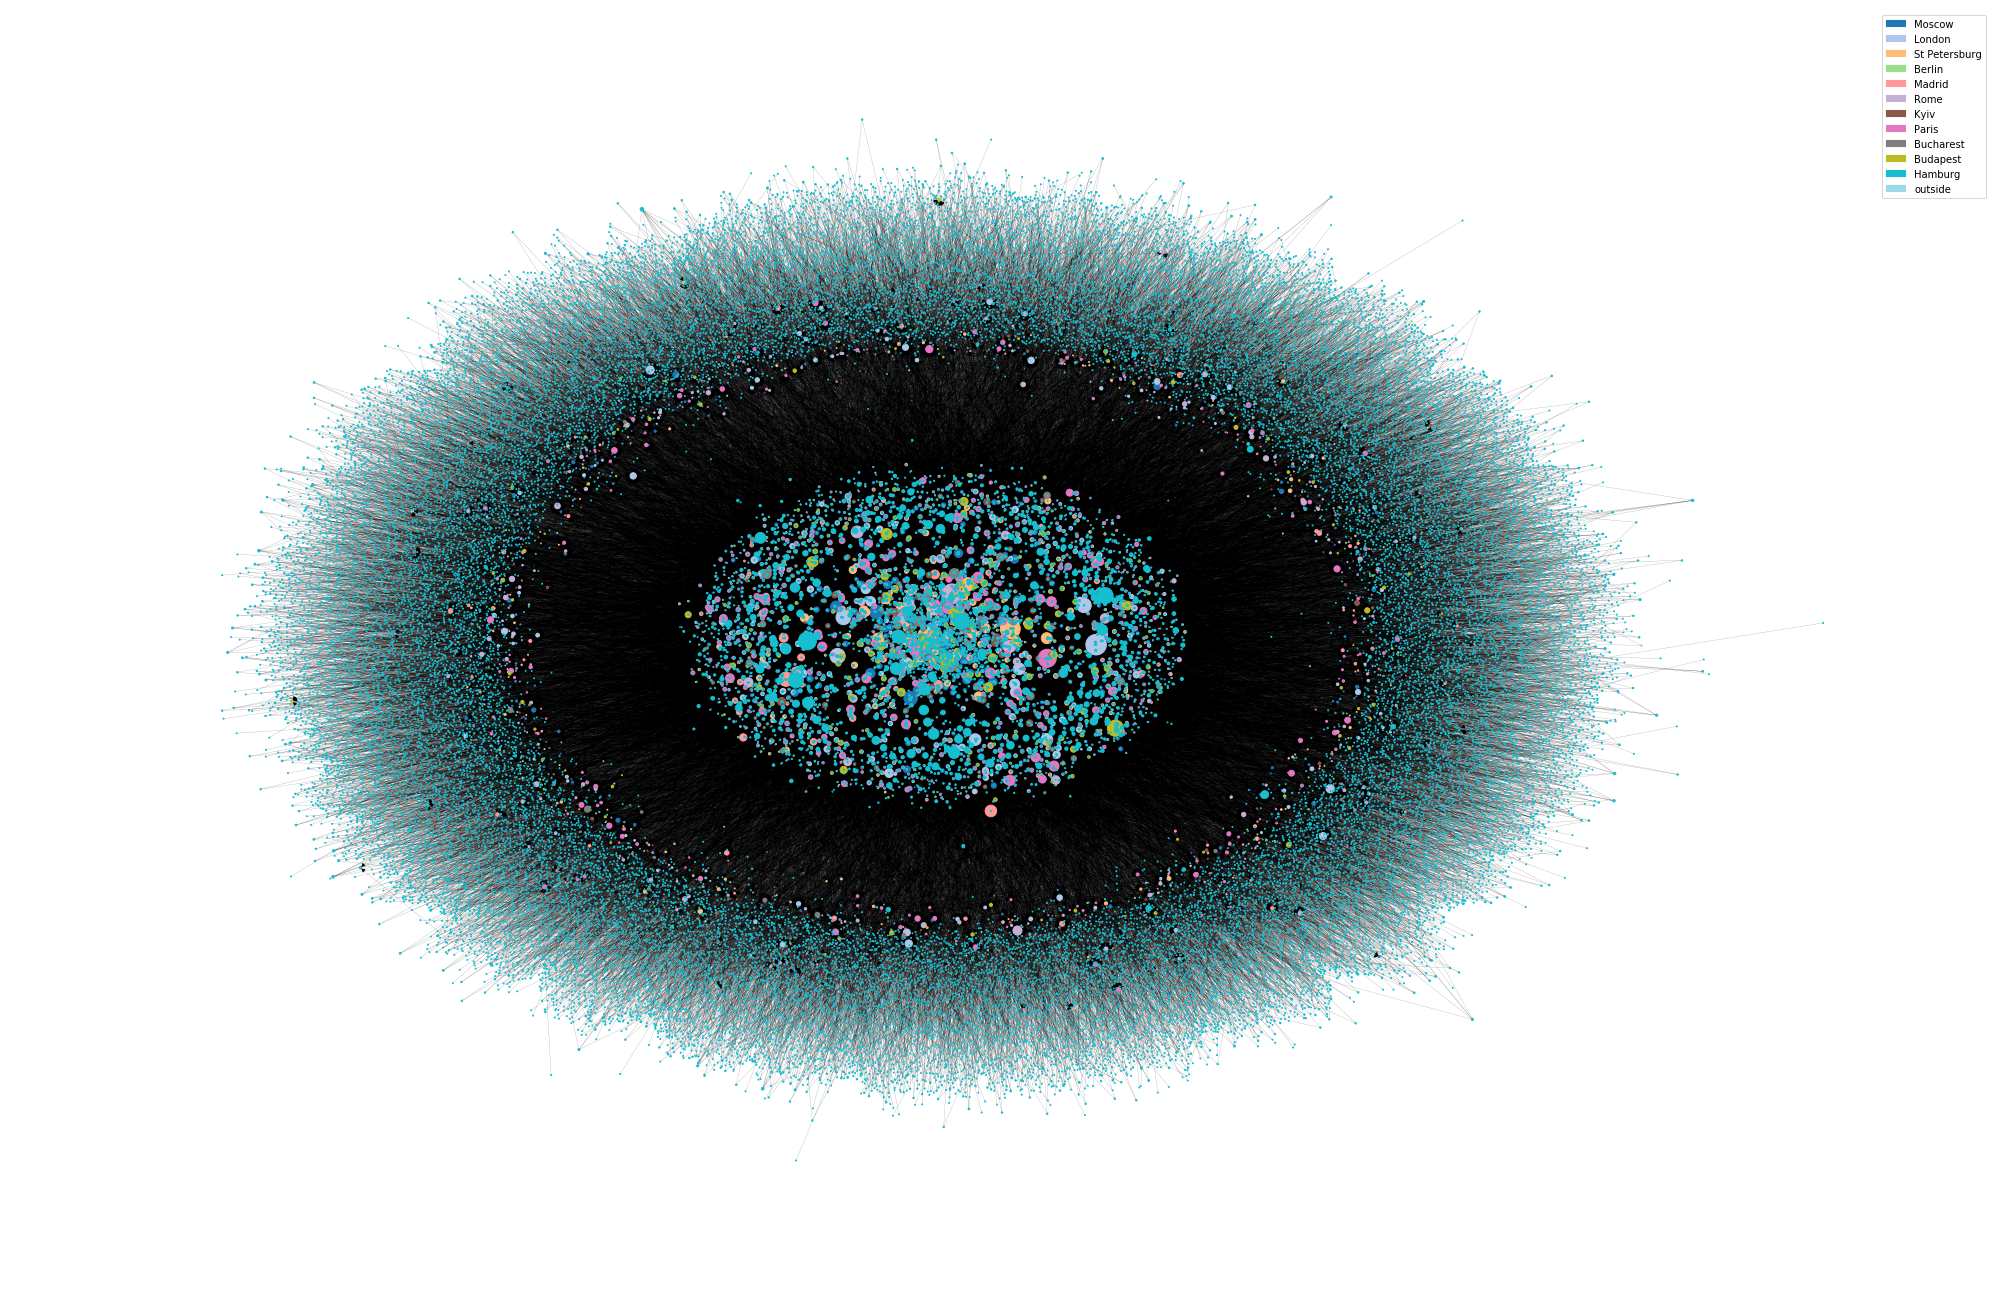

In [13]:
fig, ax = plt.subplots(figsize=(34.72,23.17))
#fig,ax = plt.figure(1,)
nx.draw(G,pos=positions,width=0.1,node_size=[v[1] * 1 for v in d],node_color=node_color)
#plt.xlim(-300,350)
#plt.ylim(-300,300)
plt.legend(legend_city)
leg = ax.get_legend()
for idx,x in enumerate(legend_col):
    leg.legendHandles[idx].set_color(x)
#plt.savefig('Top10.png')
plt.show()